# Mechanism of Action Prediction

The conventional approach to HCS analysis is a multi-stage pipeline, consisting of a sequence of modules of image and statistical analysis, comprising cell segmentation and hand-crafted feature extraction. The aim is to ascribe a phenotypic profile to each cell population to serve as the basis of comparison. Each profile will take the form of a vector $p \in \mathcal{R}^D$ of some dimensionality D and is constructed according to four ordered methodological properties: measurement unit, feature representation, dimensionality reduction, and aggregation strategy. Certain properties may be omitted by some approaches, or subsumed to a common framework, such as a neural network, that may perform each task simultaneously.

![](img/pipeline.png)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import division

import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from src.utils import *

Using TensorFlow backend.


### Imports

In [2]:
metadata_file = 'PlateMap-KPP_MOA.xlsx'
df_metadata = pd.read_excel(metadata_file).set_index('well')

# Create drug type column
df_metadata.loc[df_metadata['content'] != 'DMSO', 'category'] = 'Perturbation'
df_metadata.loc[df_metadata['content'] == 'DMSO', 'category'] = 'DMSO'
df_metadata.loc[df_metadata['content'] == 'None', 'category'] = 'None'
df_metadata.loc[df_metadata['content'] == 'Olaparib', 'category'] = 'Positive'
df_metadata.loc[df_metadata['content'] == 'Cisplatine', 'category'] = 'Positive'

# Remove drugs
df_metadata = df_metadata.drop(df_metadata[df_metadata['moa'] == 'Wild'].index)

# Remove wells without content
df_metadata = df_metadata[~df_metadata.content.isnull()]

In [3]:
from src.feature_reader import FeatureReader

cecog_out = './cecog_out_propagate_0.5'
channels = ['primary__primary4', 'secondary__propagate', 'tertiary__expanded']

plates = {'mda231' : '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231',
          'mda468' : '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'}

plate_data = {}

# initialise common wells
common_wells = set(df_metadata.index)

for cell_line in plates.keys():
    ch5_path = '%s/%s/hdf5/' % (cecog_out, plates[cell_line])
    fr = FeatureReader(plates[cell_line], ch5_path, channels, cell_line)
    fr.read_all()
    fr.data['cell_line'] = cell_line
    plate_data[cell_line] = fr

    problem_feature = 'primary__primary4_dyn_distance_radius_3'
    fr.data = fr.data.drop(problem_feature, axis=1)
    fr.feature_names.remove(problem_feature)

    all_wells = set(plate_data[cell_line].data['well'].unique())
    common_wells = common_wells.intersection(all_wells)

Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!
Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!


In [4]:
# Remove drugs without wells
df_metadata = df_metadata[df_metadata.index.isin(common_wells)]
top_k_wells = list(df_metadata.moa.value_counts().head(8).index)

for fr in plate_data.values():
    # Join metadata
    fr.join_plate_map(df_metadata.reset_index())
    fr.data = fr.data[fr.data.moa.isin(top_k_wells)]
    fr.data = fr.data[~fr.data['content'].isnull()]

mda231_moa = np.unique(plate_data['mda231'].data.moa)
mda468_moa = np.unique(plate_data['mda468'].data.moa)
assert(np.all(mda231_moa == mda468_moa))
moas = mda231_moa
print('No. MOAs: %d' % moas.shape[0])

No. MOAs: 8


With 8 MOAs, random prediction has an accuracy of 12.5%. However, as we are performing leave-one-out cross validation, there is in fact a $4/39 \approx 10.25\%$ chance of randomly guessing the correct MOA.

In [5]:
moa_wells = [np.unique(fr.data[fr.data.moa == moa]['well']) for moa in moas]

# choose dataset_index in range(60)
dataset_index = 59
# read pre-sampled wells from file
df_wells = pd.read_csv('./datasets.csv', index_col=0)
sample_wells = list(df_wells.loc[dataset_index])

for fr in plate_data.values():
    fr.data = fr.data[fr.data.well.isin(sample_wells)]
    X = fr.data[fr.feature_names].values.astype('float32')
    # Normalise dataset
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # Rewrite to dataframe
    fr.data[fr.feature_names] = X
    num_cells, num_features = X.shape
    print('Shape: %s rows, %s cols' % (num_cells, num_features))
    print('Size: %.02f Mb' % (sys.getsizeof(X) / 10 ** 6))

# select cell line for analysis
cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (cecog_out, plates[cell_line])
fr = plate_data[cell_line]

Shape: 10590 rows, 516 cols
Size: 21.86 Mb
Shape: 7402 rows, 516 cols
Size: 15.28 Mb


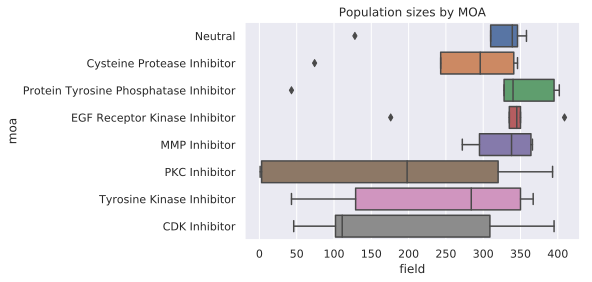

In [6]:
df_well_counts = fr.data.groupby('well').count().join(df_metadata, lsuffix='_')

sns.set(style='darkgrid')
ax = sns.boxplot(x=df_well_counts['field'], y=df_well_counts['moa'])
ax.set_title('Population sizes by MOA')

sns.reset_orig()

### MOA prediction

In [7]:
from src.lococv import construct_profiles, lococv

Drugs are assigned a class based on their mechanism of action (MOA), the cellular pathway perturbed by the drug. Given a set of drug profiles annotated with MOA classes, we can simulate reference and discovery drug sets in a leave-one-compound-out cross-validation (LOCOCV) scheme. At each fold of the cross-validation, we hold out a drug and predict its MOA class using a classifier trained on the remaining “reference” drugs. The prediction is made as the nearest neighbour (1-NN) in cosine distance between drug profiles, $d(\mathbf{p}, \mathbf{p}') = 1 − \cos\theta_{\mathbf{p},\mathbf{p′}}$. This was proposed in as an equitable way of comparing profiling algorithms. We settle for this lightweight approach as our focus here is on the discriminative power of the profiles. Note that kNN on Euclidean distance for normalised data,

\begin{align}d_E(\mathbf{u}, \mathbf{v}) &= ||\mathbf{u} - \mathbf{v}||_2 \notag \\
&= \sqrt{\mathbf{u}^T\mathbf{v} - 2\mathbf{u}^T\mathbf{v} + \mathbf{v}^T\mathbf{v}} \notag \\
&= \sqrt{2 - 2\mathbf{u}^T\mathbf{v}} \notag \\
&= \sqrt{2d_{C}(\mathbf{u}, \mathbf{v})} \notag
\end{align}

where $d_{C}(\mathbf{u}, \mathbf{v})$ is the cosine distance between $\mathbf{u}$ and $\mathbf{v}$. This is similar to a kernelised nearest centroids classifier, where the centroid is instead calculated in Euclidean space.


### Measurement unit and feature representation

#### Segmentation (HC)

The most common measurement unit is the cell itself, thus constituting a per-cell analysis. This entails an initial segmentation of the cells (their nuclei and other organelles). We segmented cell nuclei on the DAPI channel by subtracting a background image formed with a mean filter, before clipping to zero. Touching nuclei were further separated by applying the watershed transform on the inverse distance map of the foreground image. The cytoplasm was segmented from the microtubule channel (Cy5) following Jones et al. (2005).

In [8]:
df_profiles_adams = construct_profiles(fr.data, fr.feature_names, 'adams')
_, confusion = lococv(df_profiles_adams, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.1750


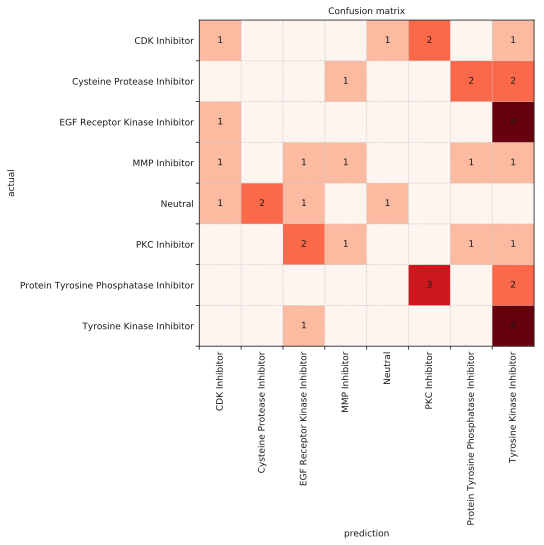

In [9]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Segmentation (CAE)

More recently, features are extracted within the layers of a convolutional neural network (CNN) trained directly on the image pixels. We benchmarked a convolutional autoencoder (CAE) following the design of Sommer et al. (2017), trained on $40\times40\times3$ inputs, formed by extracting $100\times100$px padded bounding boxes of segmented cells, rescaling, and stacking the fluorescent channels. The central hidden layer of the trained CAE is then used as a feature representation.

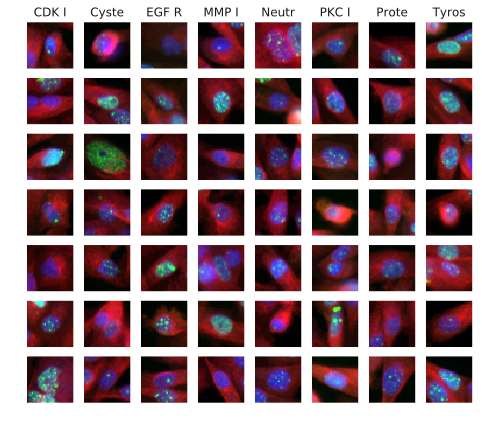

In [10]:
from src.vis_utils import image_crop_training_set, plot_moa_samples

nb_classes = len(moas)

x_img = image_crop_training_set(fr.data, ch5_path, 50, 0.4)
y_img = (fr.data.moa[:, None] == moas).astype('int32')

plot_moa_samples(x_img, fr.data, moas)

In [11]:
from src.models import conv_autoencoder

cae, cae_encoder = conv_autoencoder()
cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 40, 40, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 8)         1160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 8)         32        
__________

In [12]:
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_img, test_size=0.1)

model_checkpoint = ModelCheckpoint('./cae.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

cae.fit(x_train, x_train,
        epochs=5,
        batch_size=128,
        shuffle=True,
        validation_data=(x_val, x_val),
        callbacks=[model_checkpoint])

Train on 9531 samples, validate on 1059 samples
Epoch 1/5
9531/9531 [==============================] - 77s 8ms/step - loss: 1.3312 - val_loss: 0.1776
Epoch 2/5
9531/9531 [==============================] - 67s 7ms/step - loss: 0.1036 - val_loss: 0.0751
Epoch 3/5
9531/9531 [==============================] - 69s 7ms/step - loss: 0.0589 - val_loss: 0.0557
Epoch 4/5
9531/9531 [==============================] - 75s 8ms/step - loss: 0.0448 - val_loss: 0.0465
Epoch 5/5
9531/9531 [==============================] - 64s 7ms/step - loss: 0.0367 - val_loss: 0.0553


In [13]:
cae.load_weights('./cae.h5')

dim_encoding = np.prod(cae_encoder.output_shape[1:])
column_names = ['cae_%d' % i for i in range(dim_encoding)]

cnn_codes = cae_encoder.predict(x_img, verbose=True).reshape(x_img.shape[0], dim_encoding)
df_encoding = pd.DataFrame(cnn_codes, index=fr.data.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

10590/10590 [==============================] - 15s 1ms/step


In [14]:
df_profiles_conv = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_conv, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2500


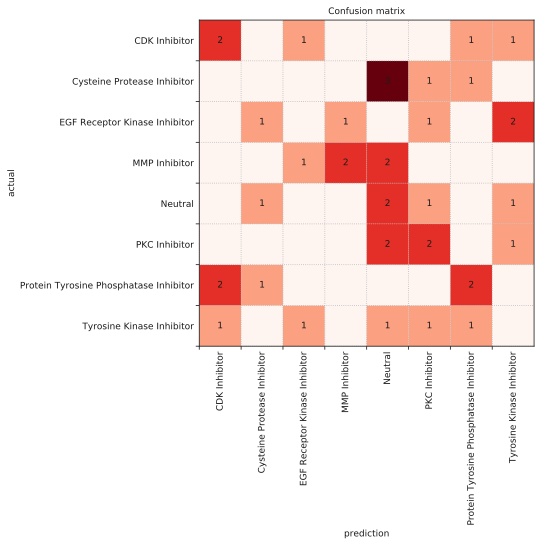

In [15]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

### Dimensionality Reduction
Dimensionality reduction requires some function $enc : X \to Z$ where $Z \in \mathbb{R}^{N \times M}$ , with reduced dimensionality $M < D$. Reduction may make drug profile comparison more robust by capturing the essential information in lower dimension, or it might lead to an interpretable representation.

#### PCA + whitening
We applied PCA on the handcrafted features, selecting $40$ of the $516$ features, retaining $\sim90\%$ of the energy on average. We further whitened the latent features.

In [16]:
from sklearn.decomposition import PCA

nb_components = 40

X = fr.data[fr.feature_names].values

pca_model = PCA(n_components=nb_components, whiten=True)
embedding = pca_model.fit_transform(X)

print('Explained variance: %.02f' % pca_model.explained_variance_ratio_.cumsum()[-1])

column_names = ['pca_%d' % i for i in range(nb_components)]
df_encoding = pd.DataFrame(embedding, index=fr.data.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

Explained variance: 0.85


In [17]:
df_profiles_adams = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_adams, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.1750


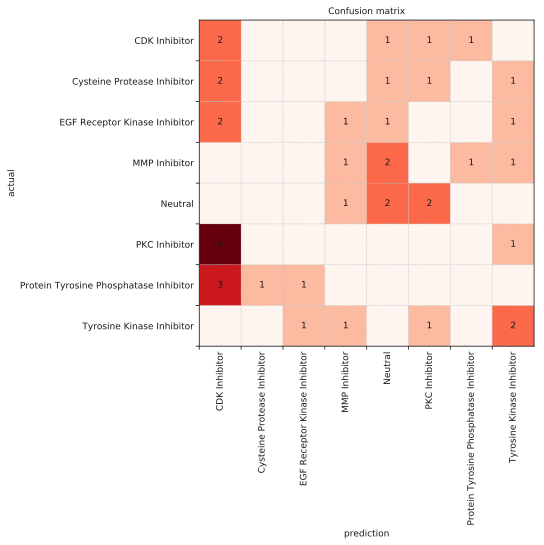

In [18]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Hierarchical Clustering
Even using optimised software (Müllner et al., 2013), hierarchical clustering is not scalable.

In [19]:
from fastcluster import linkage
from scipy.cluster.hierarchy import fcluster, dendrogram

x_train = fr.data[fr.feature_names]

start_time = time.time()

li = linkage(x_train, 'complete')

end_time = time.time()
print('Total time: %.02f seconds' % (end_time - start_time))

Total time: 42.50 seconds


In [20]:
""" extract labels from linkage model """
nb_clusters = 80

labels = fcluster(li, nb_clusters, criterion='maxclust') - 1
one_hot_labels = one_hot_encoding(labels, nb_clusters)

column_names = ['li_%d' % i for i in range(nb_clusters)]

df_encoding = pd.DataFrame(one_hot_labels, index=x_train.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

In [21]:
df_profiles_linkage = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_linkage, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2250


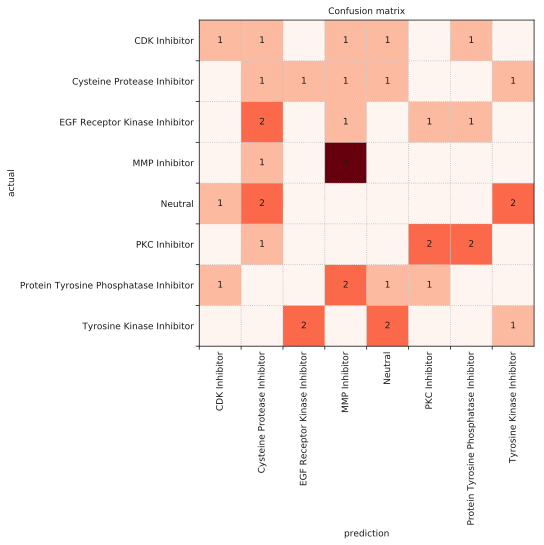

In [22]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### K-means
K-means is fast to fit approximately, in particular using mini-batch training.

In [23]:
from sklearn.cluster import KMeans, MiniBatchKMeans

nb_clusters = 100
start_time = time.time()

kmeans30 = MiniBatchKMeans(n_clusters=nb_clusters, init='k-means++').fit(X)

end_time = time.time()
print('Fitting time: %.02f seconds' % (end_time - start_time))

Fitting time: 0.28 seconds


In [24]:
""" reconstitute DataFrame """

one_hot_labels = one_hot_encoding(kmeans30.labels_, nb_clusters)

column_names = ['kmeans_%d' % i for i in range(nb_clusters)]

df_encoding = pd.DataFrame(one_hot_labels, index=fr.data.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

In [25]:
df_profiles_kmeans = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_kmeans, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.1750


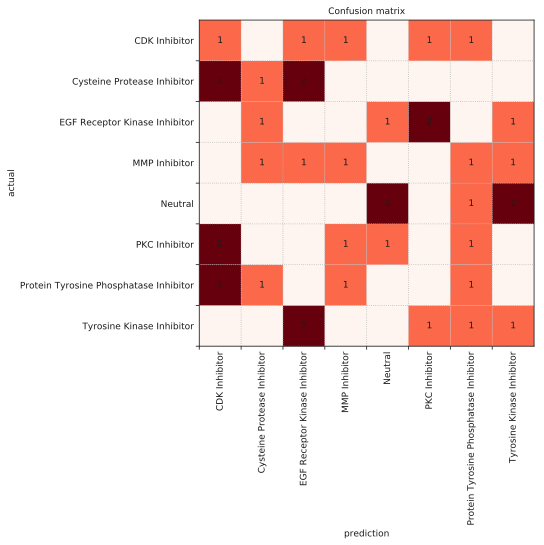

In [26]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Gaussian Mixture Models

In [27]:
from sklearn.mixture import GaussianMixture

nb_clusters = 100

start_time = time.time()

gmm = GaussianMixture(n_components=nb_clusters, init_params='kmeans')
gmm.fit(X)

end_time = time.time()
print('Fitting time: %.02f seconds' % (end_time - start_time))

Fitting time: 68.19 seconds


In [28]:
""" reconstitute DataFrame """

pred = gmm.predict_proba(X)

column_names = ['gmm_%d' % i for i in range(nb_clusters)]

df_encoding = pd.DataFrame(pred, index=fr.data.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

In [29]:
df_profiles_gmm = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_gmm, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2500


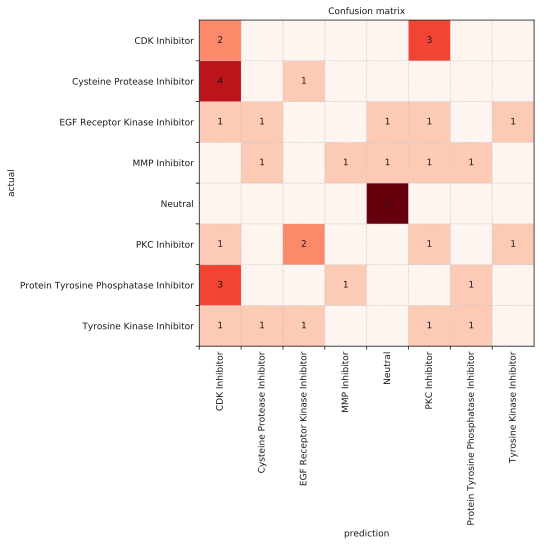

In [30]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Autoencoders

In [31]:
from src.models import autoencoder

X = fr.data[fr.feature_names].values
num_features = X.shape[1]
dim_encoder = 100

model, encoder = autoencoder(num_features, dim_encoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 516)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               51700     
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
activation_6 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 516)               52116     
Total params: 104,216
Trainable params: 104,016
Non-trainable params: 200
_________________________________________________________________


In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(X)

model.fit(x_train, x_train, epochs=20, batch_size=256,
          shuffle=True, validation_data=(x_test, x_test))

Train on 7942 samples, validate on 2648 samples
Epoch 1/20
7942/7942 [==============================] - 1s 139us/step - loss: 0.9939 - val_loss: 0.7801
Epoch 2/20
7942/7942 [==============================] - 1s 95us/step - loss: 0.6841 - val_loss: 0.6290
Epoch 3/20
7942/7942 [==============================] - 1s 67us/step - loss: 0.5556 - val_loss: 0.5489
Epoch 4/20
7942/7942 [==============================] - 1s 150us/step - loss: 0.4834 - val_loss: 0.5125
Epoch 5/20
7942/7942 [==============================] - 1s 128us/step - loss: 0.4390 - val_loss: 0.4766
Epoch 6/20
7942/7942 [==============================] - 1s 74us/step - loss: 0.4120 - val_loss: 0.4537
Epoch 7/20
7942/7942 [==============================] - 1s 110us/step - loss: 0.3927 - val_loss: 0.4548
Epoch 8/20
7942/7942 [==============================] - 1s 122us/step - loss: 0.3800 - val_loss: 0.4125
Epoch 9/20
7942/7942 [==============================] - 1s 102us/step - loss: 0.3654 - val_loss: 0.4278
Epoch 10/20
7942/79

In [33]:
encoding = encoder.predict(X, verbose=True)
column_names = [str(i) for i in range(dim_encoder)]
df_encoding = pd.DataFrame(encoding, index=fr.data.index, columns=column_names)
df_encoding['well'] = fr.data.well
df_encoding = df_encoding.join(df_metadata, on='well')

10590/10590 [==============================] - 0s 44us/step


In [34]:
df_profiles_ae = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_ae, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2250


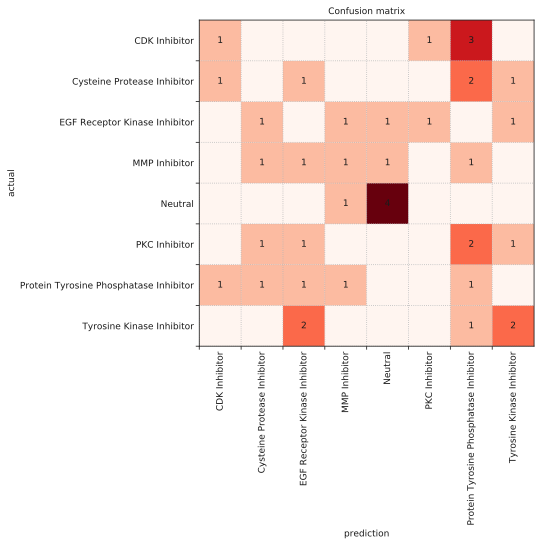

In [35]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Random forest (MIL)
Supervised classification of individual cells (Neumann et al., 2010) is one way of achieving this, as each cell is represented either by a one- hot binary vector $\mathbf{z}_i \in {0, 1}^M$ or by a vector of probabilities $\mathbf{z}_i \in [0, 1]^M$ where $\sum_j z_{ij} = 1$ and $M$ is the number of classes, in effect, the new dimensionality. There are two main drawbacks to this: the manual effort involved in creating a ground truth, and the difficulty in choosing a suitable ontology, particularly where differentiated cellular phenotypes are elusive. With multiple-instance learning (MIL) one can partially circumvent these difficulties. Here, one labels each cell with the MOA of the drug of the population, thus creating a weakly supervised ground truth. As individual cells may respond differentially to perturbation, not all regions of an image may bear the hallmarks of a particular drug, but the cellular landscape can be viewed as a multiple instance bag of objects.

In [36]:
sample_size = 2

moa_wells = [np.unique(fr.data[fr.data.moa == moa]['well']) for moa in moas]

train_wells = np.array([np.random.choice(wells, size=sample_size, replace=False)
                        for wells in moa_wells]).flatten()

idx_train = fr.data.well.isin(train_wells)
idx_test = ~fr.data.well.isin(train_wells)

x_train = fr.data[idx_train][fr.feature_names]
y_train = fr.data[idx_train].moa

print(x_train.shape)
print(y_train.shape)

(4734, 516)
(4734,)


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train)

model = RandomForestClassifier(n_estimators=500)
model.fit(x_tr, y_tr)

pred = model.predict(x_te)
acc = np.sum(pred == y_te) / y_te.shape[0]

print('Accuracy: %.02f' % acc)

Accuracy: 0.28


In [38]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

k = 10

top_k_features = np.array(fr.feature_names)[indices[:k]]

for feat in top_k_features:
    print(feat)

primary__primary4_granu_open_volume_1
primary__primary4_granu_open_volume_2
primary__primary4_granu_close_volume_2
primary__primary4_granu_close_volume_1
primary__primary4_granu_close_volume_3
primary__primary4_granu_open_volume_3
secondary__propagate_ls1_TAREA_max_value
secondary__propagate_ls1_CAREA_max_value
primary__primary4_ls1_INTERIA_sample_mean
secondary__propagate_ls1_CAREA_sample_mean


In [39]:
profiles = []
df_test_data = fr.data[idx_test]

for well in df_test_data.well.unique():

    x_test = fr.data[fr.data.well == well][fr.feature_names]
    y_test = fr.data[fr.data.well == well].moa

    pred = model.predict(x_test.values)
    profile = [np.sum(pred == moa) for moa in moas]
    profiles.append(profile)

**N.B.** the accuracy is measured out of 24 (rather than 40).

In [40]:
df_profiles_mil = pd.DataFrame(index=df_test_data.well.unique(), columns=moas, data=profiles)
_, confusion = lococv(df_profiles_mil, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2500


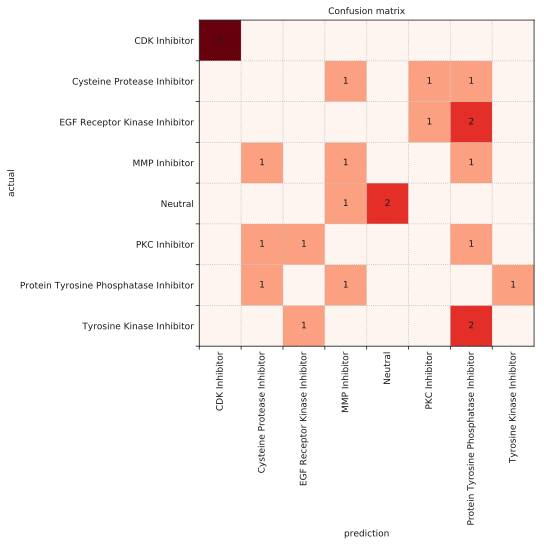

In [41]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

### Clustering of Profiles

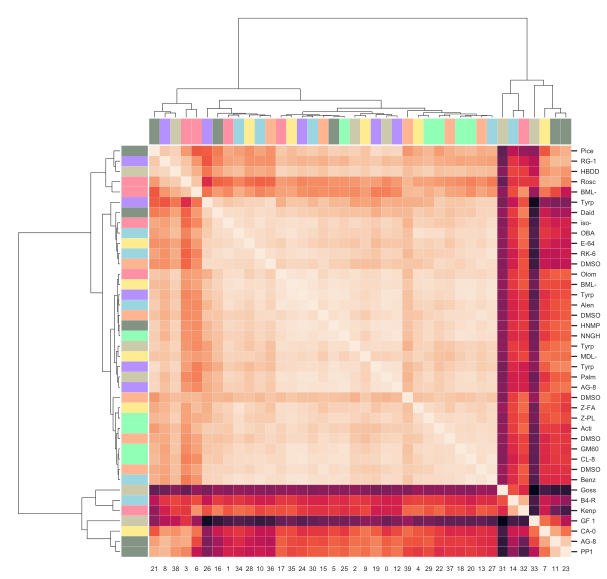

In [42]:
from src.vis_utils import palette

df_wells = plate_data['mda231'].data[['well', 'moa', 'content']]
df_wells = df_wells.drop_duplicates().set_index('well')

df_profiles = df_profiles_ae
column_names = df_profiles.columns

df_profiles = df_profiles.join(df_wells)
x_train = df_profiles.drop('moa', axis=1).values
labels = df_profiles.moa

x_train = df_profiles[column_names].values.astype('float32')
x_train /= np.linalg.norm(x_train, axis=1)[:, None]
cosines = x_train.dot(x_train.T)
dists = 1 - cosines

content_prefixes = [con[:4] for con in df_profiles.content]
df_profiles_with_labels = pd.DataFrame(index=content_prefixes, data=cosines)

moa_indices = np.argmax(moas[None, :] == df_profiles.moa[:, None], axis=1)
colours = [palette[idx] for idx in moa_indices]

fig = plt.figure()
sns.set(font_scale=0.6)

g = sns.clustermap(df_profiles_with_labels, figsize=(10, 10),
                   method='ward', row_colors=colours, col_colors=colours)

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
g.cax.set_visible(False)